# Project 2 part 2
Here I work on engineering my features! For most places you see '_eng' this is the data that is being referred to, the engineered features

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization

import statistics

from copy import deepcopy
import seaborn as sns

In [2]:
#read in data
country_data = pd.read_pickle('starter_data.pkl')
#change bools
country_data['r_home_war'] = country_data['r_home_war'].astype(float)
#drop data deficit
country_data = country_data.drop(['malnutrition','pov_ind','divorce','homeless'],axis=1)

#setting test and train data
X,y = country_data.drop('bc_BothSexes',axis=1), country_data['bc_BothSexes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13,shuffle=True)

In [3]:
#linearising feature relationships based on what pairplots showed me
X_train['gdp'] = np.log(X_train.gdp)
X_train['total_sex_ratio'] = 1/(X_train.total_sex_ratio)
X_train['guns'] = np.log(X_train.guns+1)
X_train['doc_ratio'] = np.log(X_train.doc_ratio)
X_train['pop_dens'] = np.log(X_train.pop_dens)
X_train['elevation'] = np.log(X_train.elevation)
X_train['immigrants'] = np.log(X_train.immigrants)
X_train['literacy'] = (X_train.literacy)**1/2
X_train['gdppp'] = np.log(X_train.gdppp)
X_train['population'] = np.log(X_train.population)
X_train['children'] = X_train.children**2

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [4]:
def validate_OLS(feature_matrix,target_series) :
    """
    does a k_fold validation on a potential model to determine the average adj_r2 of each validation
    
    args:
        target_series = series of dependent variable
        feature_matrix = pd.DataFrame of predictors
    returns :
        mean adjusted r2 (maybe with list of features, undecided) for that model; float
        
    IMPORTANT NOTE : with smaller data sets, you will get weird results (aka negative adj_R2); the value
    does still increase as the model improves though, so it should not be a problem long term.
    """
    kf = KFold(n_splits=5, shuffle=True, random_state = 8)
    r2s = cross_val_score(LinearRegression(), feature_matrix, target_series, cv=kf, scoring='r2')
    return np.mean(r2s)
#     adj_r2s = []
#     for r2 in r2s :
#         l1 = (1-r2)*((len(feature_matrix)/5)-1)
#         l2 = (len(feature_matrix)/5)-len(feature_matrix.columns)-1
#         adj_r2 = 1 - (l1/l2)
#         adj_r2s.append(adj_r2)
    ##spec_r2_OLS.append((statistics.mean(adj_r2s),list(feature_matrix.columns)))
    #return statistics.mean(adj_r2s)
##,list(feature_matrix.columns)

In [5]:
def high_corr_check(feature_matrix,target_series,max_corr) :
        """
    looks for any remaining high correlations and so that they can be looked at logically 
    
    args:
        target_series = np.series of dependent variable
        feature_matrix = pd.DataFrame of predictors
        max_corr = maximum correlation allowed between any two features (float; 0<max_corr<1)
    returns :
        list of highly (maybe with list of features, undecided) for that model
        
    """
        start_adj_r2 = validate_OLS(feature_matrix,target_series)
        high_corrs = []
        for col1 in feature_matrix.columns :
            for col2 in feature_matrix.columns :
                if col1 != col2 :
                    corr = np.corrcoef(feature_matrix[col1],feature_matrix[col2])[0][1]
                    if (abs(corr) >= max_corr and (col2, col1, corr) not in high_corrs): #not in is not working
                        high_corrs.append((col1,col2,corr))
        return list(set(high_corrs))

In [6]:
whole_train = pd.concat([y_train,X_train],axis=1)

In [8]:
'+'.join(whole_train.columns)

'bc_BothSexes+happy+doc_ratio+below_pov_line+gdp+unemp+med_age+homeless_dummy+total_sex_ratio+hum_freedom+econ_freedom+gen_inequality+sunny_hours+pop_dens+avg_temp+eth_div+int_users+ling_div+relig_div+alc_cons+total_bmi+r_home_war+elevation+depression+children+marr_div_dummy+urbanization+immigrants+malnutrition_dummy+pov_ind_dummy+guns+gdppp+literacy+population'

In [7]:
#here I worked on seeing what I should drop by... dropping
drop_model = smf.ols("""bc_BothSexes ~ happy+doc_ratio+below_pov_line+gdp+unemp+med_age+total_sex_ratio+hum_freedom+econ_freedom+gen_inequality+sunny_hours+pop_dens+avg_temp+eth_div+int_users+ling_div+relig_div+alc_cons+total_bmi+r_home_war+elevation+depression+children+urbanization+immigrants+malnutrition_dummy+pov_ind_dummy+guns+gdppp+literacy+population"""
                     ,data=whole_train)
results = drop_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           bc_BothSexes   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     3.811
Date:                Fri, 19 Apr 2019   Prob (F-statistic):           9.61e-08
Time:                        15:02:08   Log-Likelihood:                -214.47
No. Observations:                 146   AIC:                             492.9
Df Residuals:                     114   BIC:                             588.4
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              6.5609      6.505      1.009      0.315      -6.326      19.448
happy                  0.3407      0.227      1.503      0.136      -0.108       0.790
doc_ratio             -0.3126      0.194     -1.611      0.110      -0.697       0.072
below_pov_line         0.0004      0.011      0.040      0.968      -0.021       0.022
gdp                    0.0352      0.340      0.103      0.918      -0.639       0.709
unemp                  0.0047      0.021      0.221      0.826      -0.037       0.046
med_age               -0.0013      0.049     -0.026      0.979      -0.099       0.097
total_sex_ratio        2.4297      1.856      1.309      0.193      -1.247       6.106
hum_freedom           -0.0896      0.288     -0.312      0.756      -0.659       0.480
econ_freedom           0.0072      0.262      0.027      0.978      -0.512       0.526
gen_inequality         2.1180      1.703      1.244      0.216      -1.255       5.491
sunny_hours           -0.0003      0.000     -1.068      0.288      -0.001       0.000
pop_dens              -0.1310      0.103     -1.272      0.206      -0.335       0.073
avg_temp              -0.0745      0.025     -3.014      0.003      -0.124      -0.026
eth_div                0.5879      0.674      0.872      0.385      -0.748       1.924
int_users             -0.0254      0.011     -2.261      0.026      -0.048      -0.003
ling_div              -0.4655      0.602     -0.773      0.441      -1.659       0.728
relig_div              0.3539      0.550      0.644      0.521      -0.735       1.443
alc_cons               0.1392      0.039      3.575      0.001       0.062       0.216
total_bmi             -0.1088      0.085     -1.275      0.205      -0.278       0.060
r_home_war            -0.3215      0.346     -0.928      0.355      -1.007       0.364
elevation             -0.2315      0.123     -1.875      0.063      -0.476       0.013
depression            -0.0015      0.001     -1.986      0.049      -0.003   -4.03e-06
children              -0.0005      0.001     -0.741      0.460      -0.002       0.001
urbanization           0.0089      0.008      1.110      0.269      -0.007       0.025
immigrants             0.0237      0.115      0.207      0.837      -0.204       0.251
malnutrition_dummy    -0.2498      0.326     -0.767      0.445      -0.895       0.395
pov_ind_dummy         -0.0537      0.329     -0.163      0.871      -0.706       0.599
guns                  -0.1077      0.151     -0.713      0.477      -0.407       0.192
gdppp                  0.2502      0.365      0.686      0.494      -0.472       0.973
literacy              -0.0197      0.024     -0.835      0.405      -0.067       0.027
population             0.0146      0.343      0.043      0.966      -0.665       0.695
======================================

In [8]:
#checking high correlations
high_corr_check(X_train,y_train,.6)

[('homeless_dummy', 'marr_div_dummy', 0.9999999999999999),
 ('med_age', 'int_users', 0.8132577896148909),
 ('gdp', 'population', 0.764466649259325),
 ('doc_ratio', 'urbanization', 0.6069682350925448),
 ('med_age', 'hum_freedom', 0.6216091444672425),
 ('below_pov_line', 'gdppp', -0.6157627196375524),
 ('gen_inequality', 'literacy', -0.7371710122658813),
 ('below_pov_line', 'gen_inequality', 0.6255390428188063),
 ('med_age', 'children', -0.9188297434672362),
 ('happy', 'doc_ratio', 0.6062469487368523),
 ('gen_inequality', 'doc_ratio', -0.7776787129844542),
 ('pov_ind_dummy', 'gdppp', -0.6576162843201397),
 ('doc_ratio', 'gen_inequality', -0.7776787129844543),
 ('gdppp', 'happy', 0.6322458151836392),
 ('doc_ratio', 'gdppp', 0.7878164953123924),
 ('children', 'pov_ind_dummy', 0.6154863768746344),
 ('happy', 'int_users', 0.62625915807261),
 ('happy', 'gen_inequality', -0.7067954631323825),
 ('children', 'gdppp', -0.8239070004171735),
 ('happy', 'gdppp', 0.6322458151836391),
 ('doc_ratio', '

# A BIG MARKDOWN CELL OF NOTES I MADE TO MYSELF

## Potential to drop and why
doc_ratio, med_age are directly linked and autocorrelate <br />
hum_freedom, med_age not clearly linked and not logically connected <br />
happy, doc_ratio probably linked but any interaction would be unclear <br />
gen_inequality and pov_ind_dummy probably linked but any interaction would be unclear <br />
hum_freedom, happy probably linked but any interaction would be unclear <br />
gdppp, happy probably linked but any interaction would be unclear <br />
med_age, literacy correlation can be explained by med_age/doc_ratio correlation and doc_ratio and literacy better     
    combine to mean country development <br />
gdp, population are directly linked and autocorrelate <br />
med_age, hum_freedom are not clearly linked and not logically connected <br />
med_age, gdppp see med_age, literacy <br />
med_age, pov_ind_dummy probably linked but any interaction would be unclear <br />
pov_ind_dummy, gdppp probably linked but any interaction would be unclear <br />
med_age, avg_temp not clearly linked and not logically connected <br />
med_age, below_pov_line probably linked but any interaction would be unclear <br />
med_age, gen_inequality not clearly linked and not logically connected <br />
gen_inequality, happy probably linked but any interaction would be unclear <br />
below_pov_line, med_age see med_age, literacy <br />
marr_div_dummy, homeless_dummy, malnutrition_dummy all probably come from one reporting source - ditch two, and if removing the third increases R2, remove that one too



## Keep and why
### Lower correlation (<.65, not clearly linked but potentially still contributing)
doc_ratio, urbanisation <br />
gen_inequality, avg_temp <br />
total_bmi, literacy <br />
below_pov_line, gen_inequality <br />
urbanization, gdppp <br />

### One variable is combining after this iteration
gen_inequality, literacy <br />
gen_inequality, doc_ratio

### Logical to combine?
eth_div, ling_div = country division  <br />
**BAD! This lowered the adj r2 and raise the p_value**<br /><br />
doc_ratio, literacy, gdppp = development of country (w urbanisation, below_pov_line, gen_inequality?) <br />
**DO NOT ADD URBANIZATION, GEN INEQUALITY OR BELOW_POV, INCREASES PVALUE AND DECREASES R2 PROBS**<br />
**GDPPP ADDS .01 TO R2 BUT RAISES P VALUE BUT ONLY BY A LITTLE**<br /><br />

econ_freedom, hum_freedom = freedom in country (w gen_inequality?) <br />
**BAD! Don't combine econ and hum, increases adj r2 but raises the p value; dropping either one lowers adj r2 and raises p value; drop both to increase adj r2!**<br />

In [11]:
#trying to combine collinear features; dropping the things I thought or found I should drop during this iteration
#(this cell was run just so many times)
#I also test my logical to combine in the next few cells (you can see results above)
X_train_combining = deepcopy(X_train)
X_train_combining = X_train_combining.drop(['med_age',
                                            'econ_freedom',
                                            'hum_freedom',
                                            'pov_ind_dummy',
                                            'population',
                                            'marr_div_dummy',
                                            'homeless_dummy',
                                            'malnutrition_dummy'],
                                           axis=1)

In [12]:
X_train_combining['t_doc_lit_gdppp'] = X_train_combining.doc_ratio * X_train_combining.literacy * X_train_combining.gdppp
X_train_combining = X_train_combining.drop(['doc_ratio','literacy','gdppp'],axis=1)
#increases adj_r2, overall lower p val
#curr adj r2 .389, curr pval .016

In [13]:
whole_combine = pd.concat([y_train,X_train_combining],axis=1)
'+'.join(list(X_train_combining.columns))

'happy+below_pov_line+gdp+unemp+total_sex_ratio+gen_inequality+sunny_hours+pop_dens+avg_temp+eth_div+int_users+ling_div+relig_div+alc_cons+total_bmi+r_home_war+elevation+depression+children+urbanization+immigrants+guns+t_doc_lit_gdppp'

In [14]:
print(validate_OLS(X_train,y_train))
print(validate_OLS(X_train_combining,y_train))

0.19574980261401725
0.2906248381112378


In [15]:
combine_model = smf.ols("""bc_BothSexes ~ int_users+happy+below_pov_line+gdp+unemp+total_sex_ratio+gen_inequality+sunny_hours+pop_dens+avg_temp+eth_div+ling_div+relig_div+alc_cons+total_bmi+r_home_war+elevation+depression+children+urbanization+immigrants+guns+t_doc_lit_gdppp"""
                     ,data=whole_combine)
results = combine_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           bc_BothSexes   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     5.399
Date:                Fri, 19 Apr 2019   Prob (F-statistic):           2.73e-10
Time:                        15:06:52   Log-Likelihood:                -215.14
No. Observations:                 146   AIC:                             478.3
Df Residuals:                     122   BIC:                             549.9
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.2097      3.174      2.586      0.011       1.926      14.493
int_users          -0.0186      0.010     -1.890      0.061      -0.038       0.001
happy               0.2567      0.180      1.427      0.156      -0.099       0.613
below_pov_line     -0.0017      0.010     -0.176      0.860      -0.021       0.017
gdp                 0.0708      0.074      0.962      0.338      -0.075       0.217
unemp              -0.0005      0.020     -0.024      0.981      -0.041       0.040
total_sex_ratio     2.0505      1.664      1.232      0.220      -1.244       5.345
gen_inequality      1.4863      1.565      0.950      0.344      -1.612       4.585
sunny_hours        -0.0003      0.000     -1.183      0.239      -0.001       0.000
pop_dens           -0.1600      0.091     -1.757      0.081      -0.340       0.020
avg_temp           -0.0675      0.021     -3.144      0.002      -0.110      -0.025
eth_div             0.7533      0.597      1.262      0.209      -0.428       1.935
ling_div           -0.5511      0.577     -0.955      0.342      -1.694       0.592
relig_div           0.2360      0.513      0.460      0.646      -0.779       1.251
alc_cons            0.1336      0.035      3.859      0.000       0.065       0.202
total_bmi          -0.1095      0.075     -1.467      0.145      -0.257       0.038
r_home_war         -0.3164      0.306     -1.034      0.303      -0.922       0.290
elevation          -0.2485      0.116     -2.147      0.034      -0.478      -0.019
depression         -0.0015      0.001     -2.246      0.027      -0.003      -0.000
children           -0.0004      0.000     -0.881      0.380      -0.001       0.001
urbanization        0.0104      0.008      1.374      0.172      -0.005       0.025
immigrants          0.0671      0.096      0.696      0.488      -0.124       0.258
guns               -0.0753      0.140     -0.539      0.591      -0.352       0.201
t_doc_lit_gdppp    -0.0009      0.000     -1.985      0.049      -0.002   -2.42e-06
==============================================================================
Omnibus:                        2.479   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.290   Jarque-Bera (JB):                2.020
Skew:                           0.265   Prob(JB):                        0.364
Kurtosis:                       3.228   Cond. No.                     1.06e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Still have high p values, want to try more interactions
below_pov_line, unemp, total_sex_ratio, gen_inequality, sunny_hours, ling_div, total_bmi, r_home_war, malnutrition_dummy, children

In [16]:
X_train_refining = deepcopy(X_train_combining)

In [17]:
X_train_refining['t_eth_relig'] = X_train_refining.eth_div * X_train_refining.relig_div
X_train_refining = X_train_refining.drop(['eth_div','relig_div'],axis = 1)

In [18]:
X_train_refining['t_imm_urb_d_guns'] = X_train_refining.below_pov_line * X_train_refining.immigrants * X_train_refining.urbanization / (X.guns+1)
X_train_refining = X_train_refining.drop(['below_pov_line','immigrants','urbanization','guns'],axis = 1)

In [19]:
whole_refine = pd.concat([y_train,X_train_refining],axis=1)
'+'.join(list(X_train_refining.columns))

'happy+gdp+unemp+total_sex_ratio+gen_inequality+sunny_hours+pop_dens+avg_temp+int_users+ling_div+alc_cons+total_bmi+r_home_war+elevation+depression+children+t_doc_lit_gdppp+t_eth_relig+t_imm_urb_d_guns'

In [20]:
print(validate_OLS(X_train_combining,y_train))
print(validate_OLS(X_train_refining,y_train))

0.2906248381112378
0.3113901489742097


In [19]:
refine_model = smf.ols("""bc_BothSexes ~ happy+pop_dens+avg_temp+int_users+ling_div+alc_cons+total_bmi+elevation+depression+t_doc_lit_gdppp+t_eth_relig+t_imm_urb_d_guns"""
                     ,data=whole_refine)
results = refine_model.fit()
results.summary()
#more removing of high pvalues after refining: unemp, sunny_hours, r_home_war, total_sex_ratio

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           bc_BothSexes   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     10.16
Date:                Wed, 17 Apr 2019   Prob (F-statistic):           6.01e-14
Time:                        14:45:29   Log-Likelihood:                -218.90
No. Observations:                 146   AIC:                             463.8
Df Residuals:                     133   BIC:                             502.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           11.7553      1.720      6.833      0.000       8.353      15.158
happy                0.2707      0.124      2.176      0.031       0.025       0.517
pop_dens            -0.1849      0.078     -2.373      0.019      -0.339      -0.031
avg_temp            -0.0699      0.018     -3.885      0.000      -0.106      -0.034
int_users           -0.0128      0.007     -1.734      0.085      -0.027       0.002
ling_div            -0.8166      0.485     -1.685      0.094      -1.776       0.142
alc_cons             0.1395      0.031      4.569      0.000       0.079       0.200
total_bmi           -0.1676      0.060     -2.775      0.006      -0.287      -0.048
elevation           -0.2545      0.110     -2.324      0.022      -0.471      -0.038
depression          -0.0014      0.001     -2.394      0.018      -0.003      -0.000
t_doc_lit_gdppp     -0.0006      0.000     -1.656      0.100      -0.001       0.000
t_eth_relig          1.6265      0.747      2.178      0.031       0.150       3.103
t_imm_urb_d_guns     0.0002      0.000      1.756      0.081   -2.99e-05       0.001
==============================================================================
Omnibus:                        0.553   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.758   Jarque-Bera (JB):                0.292
Skew:                           0.091   Prob(JB):                        0.864
Kurtosis:                       3.122   Cond. No.                     2.83e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

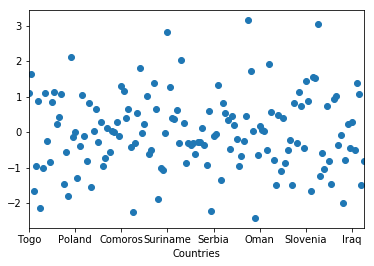

In [24]:
results.resid.plot(style='o')
#what nicely distributed residuals

In [23]:
X_final = X_train_refining.loc[:,['happy',
                       'pop_dens',
                       'avg_temp',
                       'int_users',
                       'ling_div',
                       'alc_cons',
                       'total_bmi',
                       'elevation',
                       'depression',
                       't_doc_lit_gdppp',
                       't_eth_relig',
                       't_imm_urb_d_guns']]

In [25]:
#to export all my test data
whole_test = pd.concat([y_test,X_test],axis=1)

In [26]:
#to export all my engineered train data
final_whole = pd.concat([y_train,X_final],axis=1)

In [27]:
#engineered with combining
pd.to_pickle(final_whole,'./engineerd.pkl')

In [28]:
#engineered without combining
pd.to_pickle(whole_train,'./eng_no_com.pkl')

In [29]:
#test
pd.to_pickle(whole_test,'./whole_test.pkl')